In [1]:
from data_generation import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,concat_ws, collect_list, lit,split, size, avg, udf
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType

from datasketch import MinHash, MinHashLSH
from sklearn.cluster import KMeans
from numpy import average
import numpy as np 

import shutil
import os
import numpy as np

import time
import resource
import psutil
import matplotlib.pyplot as plt
#import pandas as pd


# All functions used

In [15]:
################################################################################################################################
################################################# Question 1 ###################################################################
################################################################################################################################

def shingle(text, k=5):
    shingle_set = []
    for i in range(len(text)-k +1):
        shingle_set.append(text[i:i+k])
    return list(set(shingle_set))

def minhash_lsh(df, k_shingle, threshold):

    lsh = MinHashLSH(threshold=threshold, num_perm=128)
    minhashes = {}

    for features in df.collect():
        shingles = shingle(features["features"], k_shingle)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes[int(features["user_id"])] = m
        lsh.insert(int(features["user_id"]), m)

    replacement_candidates = {}
    for key in lsh.keys: 
        replacement_candidates[key] = lsh.query(minhashes[key]) 

    #Key: New representative, value: Similar items
    return replacement_candidates,minhashes

#Iteratively bucket unique processes together
def bucketing(replacement_candidates):
    visited_processes = set()
    new_process_dictionary = {}
    for key, values in replacement_candidates.items():
        new_values = []
        for value in values:
            if value not in visited_processes:
                visited_processes.add(value)
                new_values.append(value)
        if new_values:  # Only add non-empty lists
            new_process_dictionary[key] = sorted(new_values)
    return new_process_dictionary

def show_case(caseID,data):
    data1 = data.filter(data.user_id.isin([caseID]))
    data1.show()

def get_servers(caseID, data):
    data1 = data.filter(data.user_id.isin([caseID]))
    user_id_list = data1.select("to").rdd.flatMap(lambda x: x).collect()
    print(user_id_list)
    
def compare_cases(case1,case2,data):
    data1 = data.filter(data.user_id.isin([case1]))
    data2 = data.filter(data.user_id.isin([case2]))
    desired_column_list1 = data1.select("to").rdd.flatMap(lambda x: x).collect()
    #desired_column_list1
    desired_column_list2 = data2.select("to").rdd.flatMap(lambda x: x).collect()
    #desired_column_list2
    common_elements = np.intersect1d(desired_column_list1, desired_column_list2)
    union_elements = np.union1d(desired_column_list1, desired_column_list2)
    print(len(common_elements)/len(union_elements))


def write_df(df,file_name):
    os.makedirs('Output', exist_ok=True)
    #temporary folder to save all the temporaty files created by write.csv
    os.makedirs('temp', exist_ok=True)
    df.write.csv('temp/temp_outoput', header=True, mode="overwrite")
    part_file = [f for f in os.listdir('temp/temp_outoput') if f.startswith("part-")][0]

    shutil.move(os.path.join('temp/temp_outoput', part_file), file_name)
    shutil.rmtree('temp/temp_outoput')
    shutil.rmtree('temp')

def output_part1(dataset,k,threshold):
    data = spark.read.csv(dataset, header=True, inferSchema=True)
    df = data.withColumn("arrayColumn", concat_ws("","from", "to")).withColumn("Minhash", lit(""))
    df_grouped = df.groupBy("user_id").agg(
                                            concat_ws("",collect_list("arrayColumn")).alias("features"))
    
    replacement_candidates = minhash_lsh(df_grouped,k,threshold)
    new_process_dictionary = bucketing(replacement_candidates)    

    user_ids = list(new_process_dictionary.keys())
    output_df = data.filter(df.user_id.isin(user_ids))
    final_df = output_df.coalesce(1)
    return write_df(final_df,'Output/part1Output.csv')


################################################################################################################################
################################################# Question 2 ###################################################################
################################################################################################################################

def kmeans_clustering(df, n_clusters, max_iter):
    minhashes = []
    #for jaccard verification
    minhash_dict = {}
    user_ids = []
    final_buckets = {}
    for features in df.collect():
        shingles = shingle(features["features"], 5)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes.append(m.hashvalues)
        minhash_dict[int(features["user_id"])] = m
        user_ids.append(int(features["user_id"]))

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(minhashes)

    user_clusters = dict(zip(user_ids, kmeans.labels_))
    final_buckets = {}
    for key, value in user_clusters.items():
        if value in final_buckets:
            final_buckets[value].append(key)
        else:
            final_buckets[value] = [key]

    return final_buckets, minhash_dict


#Get averege jaccard value per bucket

def get_averege_jaccard_sim(final_buckets, minhashes,get = True):
    sims = {}
    for key, value in final_buckets.items():
        for user_id_1 in final_buckets[key]:
            for user_id_2 in final_buckets[key]:
                if user_id_1 != user_id_2:
                    sig_1 = minhashes[int(user_id_1)]
                    sig_2 = minhashes[int(user_id_2)]
                    sim = MinHash.jaccard(sig_1, sig_2)
                    if key not in sims:
                        sims[key] = [sim]
                    else:
                        sims[key].append(sim)
    total_sum = 0
    total_count = 0
    sims = dict(sorted(sims.items()))
    if get == True:
        for key, value in sims.items():
            avg_sim = average(value)
            print(key, avg_sim)
            total_sum += sum(value)
            total_count += len(value)
        
        overall_average = total_sum / total_count if total_count != 0 else 0
        print("Overall Average Jaccard Similarity:", overall_average)

    return sims

# Experiments

In [16]:
spark = SparkSession.builder \
    .appName("MySparkJob") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.instances", "10") \
    .getOrCreate()

data = spark.read.csv("data/SDG_dataset2.csv", header=True, inferSchema=True)
df_filtered_m = data.filter(data.type.isin(['Req']))
df_grouped = df_filtered_m.groupBy("user_id").agg(concat_ws("",collect_list("to")).alias("features"))
#data.show()
#df_filtered_m.show()
#df_grouped.show()

## Question 1

### Paramter-tuning for k-shingles

First we're going to see which k is the best for the k-shingles. We gonna do such a thing by investigating how computational expensive it is to compute such minhash for different values of k

In [38]:
def get_memory_usage(): 
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def get_cpu_usage(): 
    return psutil.cpu_percent(interval=None)

def get_performance(func1,func2, vals):
    #k_values = [2, 3, 4, 5, 6, 7, 8]
    results = []

    for k in vals:
        start_time = time.time()
        start_mem = get_memory_usage()
        start_cpu = get_cpu_usage()

        replacement_candidates, minhashes = func1(df_grouped, k, 0.98)
        new_process_dictionary = func2(replacement_candidates)
        
        end_time = time.time()
        end_mem = get_memory_usage()
        end_cpu = get_cpu_usage()

        duration = end_time - start_time
        mem_used = end_mem - start_mem

        results.append({
            'k': k,
            'time_seconds': duration,
            'memory_mb': mem_used,
            'unique_processes': len(new_process_dictionary),
            'cpu': end_cpu
        })
    return results

In [39]:
results = get_performance(minhash_lsh,bucketing, [3,5,7,9])

In [28]:
def plot_results(results):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('k values')
    ax1.set_ylabel('Time (seconds)', color='tab:blue')
    ax1.plot(k_values, time_seconds, marker='o', color='tab:blue', label='Time')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('CPU Usage (%)', color='tab:red')

    ax2.plot(k_values, cpu_percentages, marker='^', color='tab:red', linestyle='--', label='CPU Usage')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Performance Metrics for Different k Values')
    fig.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

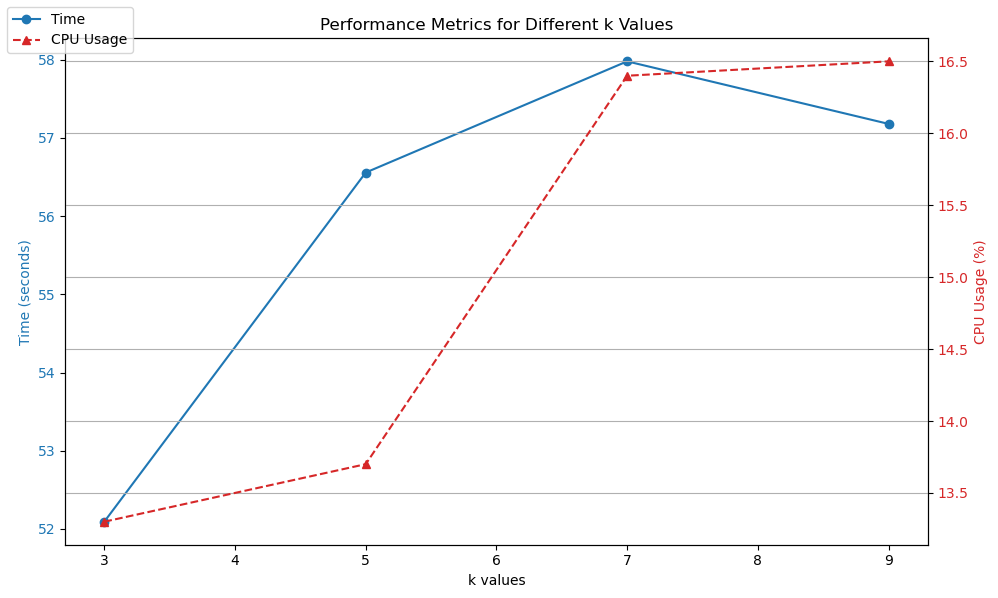

In [40]:
plot_results(results)

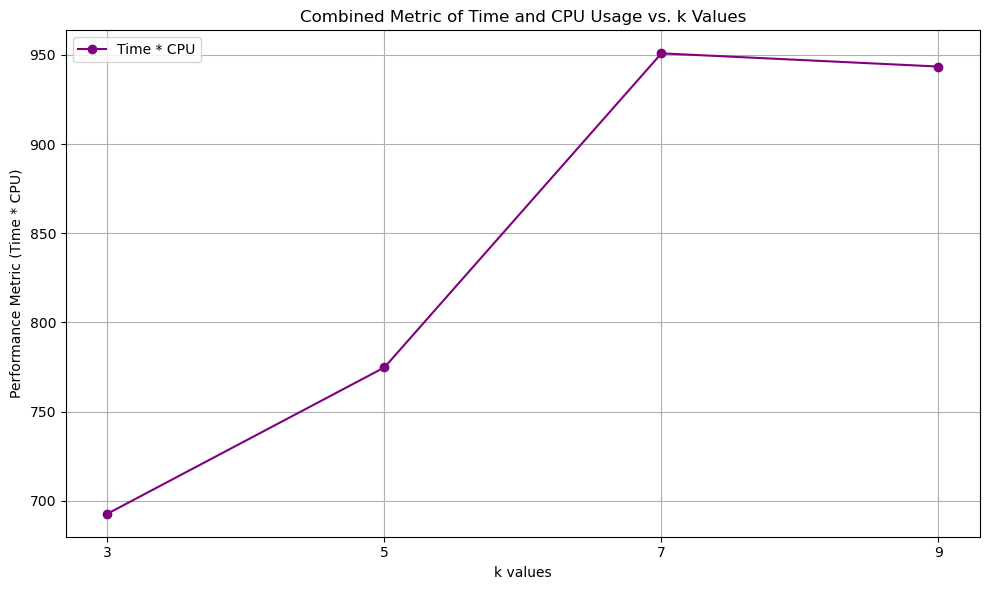

In [41]:
def plot_performances(results):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]

    # Calculate the performance metric (Product of time_seconds and cpu)
    performance_metric = [time_seconds[i] * cpu_percentages[i] for i in range(len(results))]

    # Create a figure and axis
    plt.figure(figsize=(10, 6))

    # Plot the performance metric
    plt.plot(k_values, performance_metric, marker='o', linestyle='-', color='purple', label='Time * CPU')

    # Set labels and title
    plt.xlabel('k values')
    plt.ylabel('Performance Metric (Time * CPU)')
    plt.title('Combined Metric of Time and CPU Usage vs. k Values')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_performances(results)

### Parameter-tuning for the threshold

In [17]:
shingles_udf = udf(shingle, ArrayType(StringType()))


df_filtered_m = data.filter(data.type.isin(['Req']))
df_shingles = df_filtered_m.groupBy("user_id").agg(concat_ws("", collect_list("to")).alias("trace")) \
    .withColumn("shingles", shingles_udf(col("trace"))) \
    .select("user_id", "shingles")

#df_shingles.show()
average_num_shingles = df_shingles.withColumn("list_length", size(col("shingles"))) \
                     .agg(avg("list_length").alias("average_list_length")).collect()[0][0]
average_num_shingles

34.06848660148687

Given that the average number of 5-shingles is 34, and we want to group processes with only small variations, we want that 33/34 shingles to be the same, so that we still allow for some small variations

Given that the average number of trace's characters is 38, if we use 7-shingles we would get approximately 

In [18]:
print(f"Initial number of cases: {df_grouped.count()}")
ans = minhash_lsh(df_grouped,5,0.97)
replacement_candidates7, minhash_dic = ans[0],ans[1]
new_process_dictionary7= bucketing(replacement_candidates7)
print(f"After merging cases with threshold 7-shingles: {len(new_process_dictionary7)}")

Initial number of cases: 41833


After merging cases with threshold 7-shingles: 32828


In [ ]:
sims = get_averege_jaccard_sim(replacement_candidates7, minhash_dic,get=False)

In [ ]:
keys_with_target_value = [key for key, value in sims.items() if value == min(sims.values())]
get_servers(keys_with_target_value[0],data)
get_servers(keys_with_target_value[1],data)

In [ ]:
min(sims.values())

In [ ]:
# output_part1("data/SDG_dataset2.csv",3,0.95)
# output_part1("data/SDG_dataset2.csv",5,0.95)
output_part1("data/SDG_dataset2.csv",7,0.95)

## Question 2

### Parameter tuning for Kmeans

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

minhashes = []
user_ids = []
final_buckets = {}
for features in df_grouped.collect():
    shingles = shingle(features["features"], 5)
    m = MinHash(num_perm=128)
    for shingle_item in shingles:
        m.update(shingle_item.encode("utf8"))
    minhashes.append(m.hashvalues)
    user_ids.append(int(features["user_id"]))

param_grid = {
    'n_clusters': [100, 250, 500],
    'max_iter': [100, 500, 1000],
}

kmeans = KMeans()

grid_search = GridSearchCV(kmeans, param_grid, cv=5)

grid_search.fit(minhashes)

best_param = grid_search.best_params_
best_model = grid_search.best_estimator_

print("The best parameters are: " , best_param )
print("The best model is: ", best_model)

### Step 1: Find and merge

In [ ]:
replacement_candidates = minhash_lsh(df_grouped,5,0.7)
new_process_dictionary = bucketing(replacement_candidates)
print(len(replacement_candidates))
print(len(new_process_dictionary))

### STEP 2: Find/cluster similar items

In [ ]:
#from sklearn.model_selection import train_test_split, GridSearchCV

users = []
for key in new_process_dictionary:
    users.append(key)

filtered_df = df_grouped[df_grouped['user_id'].isin(users)]

final_buckets, minhashes = kmeans_clustering(filtered_df,500,100)

### Verification

In [ ]:
get_averege_jaccard_sim(final_buckets, minhashes)


# Old

In [ ]:
#print(f"Initial number of cases: {df_grouped.count()}")
# replacement_candidates3 = minhash_lsh(df_grouped,3,0.98)
# new_process_dictionary3 = bucketing(replacement_candidates3)
#print(f"After merging cases with threshold 3-shingles: {len(new_process_dictionary3)}")

In [ ]:
# df_split = df_grouped.withColumn("feature_length", size(split(col("features"), "S")))
# average_length = df_split.agg(avg("feature_length")).collect()[0][0]

# windowSpec = Window.partitionBy(F.lit(1)).orderBy("feature_length")
# df_split = df_split.withColumn("row_number", F.row_number().over(windowSpec))
# total_count = df_split.count()

# if total_count % 2 == 0:
#     median_index1 = total_count // 2
#     median_index2 = median_index1 + 1
#     median_value = df_split.filter(col("row_number").isin([median_index1, median_index2])) \
#                                   .agg(avg("feature_length")).collect()[0][0]
# else:
#     median_index = (total_count // 2) + 1
#     median_value = df_split.filter(col("row_number") == median_index) \
#                                   .select("feature_length").collect()[0][0]
    
# print(f"Average number of requests: {average_length}")
# print(f"Median number of requests: {median_value}")


#Given that both the average and the median are close to 13, which shows that the dataset is symetricly distributed when it comes to how many 
#requests are performed, we gonna assume that two cases have a small variation iif the number of different requests is around 1. To get an 
# #approximation of the threshold, we're going to use the resutls shown before, so we assume that 12/13 are the same. Given this, we decided 
# to use a threshold of 95%